In [2]:
import numpy as np
import torch.nn as nn
import torch
from torch.nn import Module
import data_loader
import torch.optim as optim
from tqdm import tqdm

# DATA PREP

In [3]:
# specify file names of the CoNLL corpus 
train_dataloader, dev_dataloader, test_dataloader, vocabulary, tagset, pretrained_embeddings = data_loader.load("UD_German-GSD-master/de_gsd-ud-train.conllu", 
                                                                                                                "UD_German-GSD-master/de_gsd-ud-dev.conllu", 
                                                                                                                "UD_German-GSD-master/de_gsd-ud-test.conllu")

# create embeddings with size (length_vocabulary, 300)
embedding = torch.nn.Embedding(num_embeddings=len(vocabulary), embedding_dim=300)
embedding.weight.data = pretrained_embeddings
embedding.weight.requires_grad = False

# SAMPLE DATA EXPLORATION

In [4]:
# a sentence tensor with token embeddings and tag IDs
sample = train_dataloader.dataset[0]
sample

{'sentence': tensor([   58,   282,   443,     3,  2300, 20144,     4,   806,     3,    61,
           948,    45,   171,  4091,    57,     2]),
 'tags': tensor([7, 6, 0, 1, 6, 0, 2, 0, 1, 7, 5, 8, 8, 0, 3, 1])}

In [5]:
# same sentence with words; </s> is for the sentence end
vocabulary.lookup_tokens(list(sample["sentence"]))

['sehr',
 'gute',
 'beratung',
 ',',
 'schnelle',
 'behebung',
 'der',
 'probleme',
 ',',
 'so',
 'stelle',
 'ich',
 'mir',
 'kundenservice',
 'vor',
 '</s>']

In [6]:
# same sentence POS tags
tagset.lookup_tokens(list(sample["tags"]))

['ADV',
 'ADJ',
 'NOUN',
 'PUNCT',
 'ADJ',
 'NOUN',
 'DET',
 'NOUN',
 'PUNCT',
 'ADV',
 'VERB',
 'PRON',
 'PRON',
 'NOUN',
 'ADP',
 'PUNCT']

# MODEL CLASS

In [57]:
class NNTagger(nn.Module):
    """
    A POS tagger for the German sentences.
    Predicts POS tag for a tensor of embeddings of words.
    A 1 layer LSTM.
    """
    
    # params of the model
    def __init__(self,
                input_size: int,
                number_tags: int,
                hidden_size: int):
        """

        :param input_size: the size of the input layer - length (n. of cols) of an input tensor; must be equal to embedding length
        :param number_tags: the length of POS tag set - length (n. of cols) of an output;
        :param hidden_size: the size of the hidden layer
        """
        super(NNTagger, self).__init__()

        self.layer1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True) #[inp=300, out=300]; hidden_size - number of hidden units
        self.layer2 = nn.Linear(in_features=hidden_size, out_features=number_tags) #[inp=300, out=18]
        
        
    # feed-forward function
    def forward(self, 
                input_sent):
        """
        Gets an input batch and feeds it through the layers of the network to get the output predictions for each input
        :param input_sent: a batch of tensors corresponding to sentences; shape: (batch_size, sentence_length, embedding_length)
        :return: the predictions of the model; shape: (batch_size, sentence_length, number_tags)
        """
        # feed input batch into the lstm layer
        out_lstm_layer, _ = self.layer1(input_sent)

        # feed output of lstm layer to the linear layer
        out_linear_layer = self.layer2(out_lstm_layer)

        return out_linear_layer


# TRAINING FUNCTION

In [58]:
def train_model(model: Module, 
                train_data, dev_data,
                num_epochs: int,
                optimizer_type,
                loss_function,
                learning_rate: float,
                embedding) -> None:
    """
    Does one commplete training run for N epochs
    :param model: a pytorch model
    :param train_data: a dataloader for getting the training instances
    :param num_epochs: the number of epochs
    :param optimizer_type: the type of optimizer
    :param loss_function: the type of the loss function
    :param learning_rate: the learning rate for the optimizer
    :param embedding: embedding object with size (vocab_length, 300)
    :return:
    """
    
    # for stats
    loss_per_epoch = []
    train_acc_per_epoch = []
    dev_acc_per_epoch = []
   
    # brings model into training mode
    model.train()

    optimizer = optimizer_type(params=model.parameters(), lr=learning_rate)

    # runs training for specified number of epochs
    for epoch in tqdm(range(num_epochs)):
        
        loss_total = 0
        sent_total = 0

        for sent in train_data:
            
            # transforms one-hot encoding into embedding tensor
            input_sent = torch.stack([embedding.weight.data[word] for word in sent[0][0]])
            # wraps into one more tensor to keep the right dimentionality: (batch_size=1, sent_length, embedding_length)
            input_sent = torch.stack([input_sent])

            # computes model predictions with current model parameters
            model_output = model(input_sent)

            # computes Loss for current sent
            loss = loss_function(input=model_output[0], target=sent[0][1])
            loss_total += loss.item()
            sent_total += 1

            optimizer.zero_grad()

            # back-propagate error 
            loss.backward()

            # updates parameters
            optimizer.step()
        
        train_acc, dev_acc = evaluate(tagger, [train_data, dev_data])
        train_acc_per_epoch.append(train_acc.item())
        dev_acc_per_epoch.append(dev_acc.item())
        loss_per_epoch.append(loss_total / sent_total)

    return loss_per_epoch, train_acc_per_epoch, dev_acc_per_epoch

# EVALUATION FUNCTION

In [59]:
# brings model in evaluation mode
def evaluate(model, eval_set):
    tagger.eval()
    
    correct_preds = [0 for ds in eval_set]
    num_tokens = [0 for ds in eval_set]
    final_accs = [0 for ds in eval_set]
    
    with torch.no_grad():
        for ds in range(len(eval_set)):
            for sent in eval_set[ds]:

                # model output of size (sent_length, num_tags), logit vals
                input_sent = torch.stack([embedding.weight.data[word] for word in sent[0][0]])
                input_sent = torch.stack([input_sent])
                sent_pred = tagger(input_sent)
                sent_pred = torch.sigmoid(sent_pred)
                # prediction vector of size (1, pred_tag_inds)
                sent_pred = torch.argmax(sent_pred, dim=2)

                # target vec (1, tag_inds)
                target_vec = sent[0][1]
                num_tokens[ds] += len(target_vec)

                # gets accuracy on the whole data
                correct_preds[ds] += torch.sum(sent_pred == target_vec)
        
            final_accs[ds] = (correct_preds[ds] / num_tokens[ds]) * 100
    
            #print(f"ACCURACY: {torch.round(final_accs[ds])}% in {ds} ds")
    return final_accs

# MODEL INITIALIZATION

In [83]:
# create an instance of the model to train
hidden_size = 150
input_size = 300
num_tags = len(tagset)

tagger = NNTagger(input_size=input_size, number_tags=num_tags, hidden_size=hidden_size)


### Hyperparameters ###

epochs = 30
learning_rate = 0.01
optimizer = optim.Adam
loss_function = nn.functional.cross_entropy

# MODEL TRAINING

In [85]:
# runs a complete training loop
loss_per_epoch, train_acc_per_epoch, dev_acc_per_epoch = train_model(model=tagger, 
                                                                     train_data=train_dataloader, 
                                                                     dev_data=dev_dataloader, 
                                                                     num_epochs=epochs,
                                                                     optimizer_type=optimizer, 
                                                                     loss_function=loss_function, 
                                                                     learning_rate=learning_rate, 
                                                                     embedding=embedding)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [25:37<00:00, 153.75s/it]


In [29]:
import matplotlib.pyplot as plt

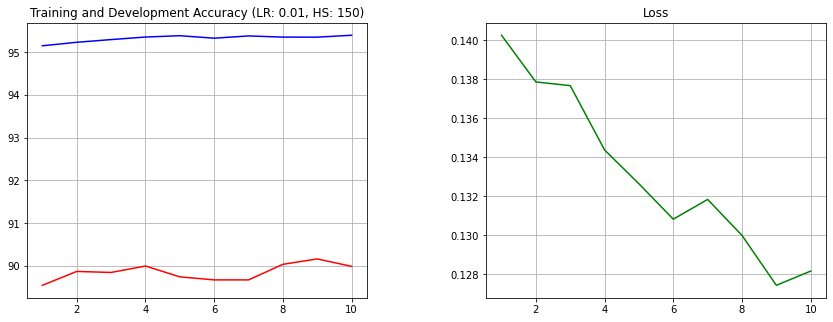

In [86]:
# visualize training

plt.figure()

x = [i for i in range(1, epochs+1, 1)]

# training acc
plt.subplot(221)
plt.plot(x, train_acc_per_epoch, label="train", color="blue")
plt.plot(x, dev_acc_per_epoch, label="dev", color="red")
plt.title(f'Training and Development Accuracy (LR: {learning_rate}, HS: {hidden_size})')
plt.grid(True)

# development acc
plt.subplot(222)
plt.plot(x, loss_per_epoch, color="green")
plt.title('Loss')
plt.grid(True)

plt.subplots_adjust(top=1.99, bottom=0.08, left=0.10, right=1.95, hspace=0.0,
                    wspace=0.35)

plt.show()

# EVALUATION ON TEST DATA

In [87]:
test_acc = evaluate(tagger, [test_dataloader])
print(f"Accuracy of test data: {round(test_acc[0].item(), 2)}")

Accuracy of test data: 89.93


# SAVE AND LOAD MODEL PARAMS

In [56]:
# save the model parameters in a .pt file
torch.save(tagger.state_dict(), "./models/model_parameters_taggerLR01HS150.pt")

In [84]:
# load trained model parameters again

# first create an instance of the model class
tagger = NNTagger(input_size=input_size, number_tags=num_tags, hidden_size=hidden_size)

# then load the trained parameters
tagger.load_state_dict(torch.load("./models/model_parameters_taggerLR01HS150.pt"))
epochs = 10

# POS DISTR

In [88]:
from collections import defaultdict

In [138]:
def evaluate_pos(model, eval_set):
    tagger.eval()
    
    correct_preds = [0 for ds in eval_set]
    correct_preds_pos = defaultdict(int)
    pos_num = defaultdict(int)
    num_tokens = [0 for ds in eval_set]
    final_accs = [0 for ds in eval_set]
    
    with torch.no_grad():
        for ds in range(len(eval_set)):
            for sent in eval_set[ds]:

                # model output of size (sent_length, num_tags), logit vals
                input_sent = torch.stack([embedding.weight.data[word] for word in sent[0][0]])
                input_sent = torch.stack([input_sent])
                sent_pred = tagger(input_sent)
                sent_pred = torch.sigmoid(sent_pred)
                # prediction vector of size (1, pred_tag_inds)
                sent_pred = torch.argmax(sent_pred, dim=2)

                # target vec (1, tag_inds)
                target_vec = sent[0][1]
                num_tokens[ds] += len(target_vec)

                # gets accuracy on the whole data
                for i in range(len(target_vec)):
                    pos_num[target_vec[i].item()] += 1
                    if sent_pred[0,i] == target_vec[i]:
                        correct_preds_pos[target_vec[i].item()] += 1
                
        
            final_accs[ds] = (correct_preds[ds] / num_tokens[ds]) * 100
    
            #print(f"ACCURACY: {torch.round(final_accs[ds])}% in {ds} ds")
    for tag in correct_preds_pos:
        correct_preds_pos[tag] /= pos_num[tag]
    pos_total = sum([i for i in pos_num.values()])
    
    return correct_preds_pos, pos_num, pos_total

In [139]:
test_acc_pos, pos_num, pos_total = evaluate_pos(tagger, [test_dataloader])

In [132]:
pos = list(test_acc_pos.keys())
pos_str = tagset.lookup_tokens(pos)
for i in range(len(pos_str)):
    print(f"{pos_str[i]}: {round(test_acc_pos[pos[i]], 2)}")

DET: 0.95
NOUN: 0.88
AUX: 0.92
ADP: 0.98
PUNCT: 0.99
CCONJ: 0.94
PRON: 0.88
ADJ: 0.85
ADV: 0.75
NUM: 0.82
VERB: 0.82
SCONJ: 0.77
_: 0.99
PROPN: 0.9
PART: 0.82
SYM: 0.5
X: 0.04


In [142]:
pos = list(pos_num.keys())
pos_str = tagset.lookup_tokens(pos)
for i in range(len(pos_str)):
    print(f"{pos_str[i]}: {round(pos_num[pos[i]]/pos_total, 6)}")

DET: 0.12032
NOUN: 0.185488
AUX: 0.040902
ADP: 0.095755
PUNCT: 0.141068
CCONJ: 0.027606
ADV: 0.076795
PRON: 0.054734
ADJ: 0.060816
NUM: 0.01586
PROPN: 0.060995
VERB: 0.07912
SCONJ: 0.009599
_: 0.016337
PART: 0.01258
X: 0.00155
SYM: 0.000238
INTJ: 0.000238
